<a href="https://colab.research.google.com/github/how-to-train-your-model/data-science-portfolio/blob/main/MSDS451_A3_Creating_features_from_a_price_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import bz2
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
plt.style.use('classic')

from statsmodels.tsa.stattools import adfuller



In [ ]:
# Allows for muliple output in one cell window
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Allows for viewing the complete data in a single window 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l "/content/drive/My Drive/Colab_Notebooks/MSDS-451/W3"

total 1017
-rw------- 1 root root 654072 Feb  6 02:58 'A3_MSDS451_Pant_Creating features from a price series.docx'
-rw------- 1 root root 124919 Feb  6 02:49 'MSDS451_A3_Pant_Creating features from a price series.ipynb'
-rw------- 1 root root 261387 Feb  4 22:18  USO.CSV


In [ ]:
w3_files = "/content/drive/My Drive/Colab_Notebooks/MSDS-451/W3"

In [ ]:
df = pd.read_csv(w3_files+"/USO.CSV")
df.shape
df.head(10)

df.dtypes


(3308, 7)

,Date,Open,High,Low,Close,UnAdjustedClose,Volume
0,20060410,68.25,68.50,67.67,68.02,68.02,38779
1,20060411,68.32,68.39,67.30,68.20,68.20,12971
2,20060412,68.22,68.81,67.81,67.84,67.84,12483
3,20060413,67.50,68.99,67.40,68.82,68.82,5607
4,20060417,69.20,69.90,68.68,69.79,69.79,9177
5,20060418,70.10,71.05,69.57,70.75,70.75,9227
6,20060419,70.58,72.16,70.49,71.85,71.85,7898
7,20060420,71.92,72.16,70.51,71.09,71.09,8432
8,20060421,70.89,73.23,70.80,72.81,72.81,10658
9,20060424,71.40,72.45,70.79,71.01,71.01,10423


Date                  int64
 Open               float64
 High               float64
 Low                float64
 Close              float64
 UnAdjustedClose    float64
 Volume               int64
dtype: object

# Question 1

Download the USO.csv Download USO.csvfile which contains the daily bars of the US Oil (Exchange Traded) Fund. Use the provided functions getWeights_FFD, fractDiff.FFD, and findMinD, to find the minimum fractional dimension d that will turn this price series into a stationary series. 

In [ ]:
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w=getWeights_FFD(d,thres)
    df={}
    for name in series.columns:
        df_=pd.Series(series[name].values,index=series.index).fillna(method='ffill').dropna()
        x=pd.Series(0,index=df_.index)
        for k in range(w.shape[0]):
            x=x+w[k,0]*df_.shift(-k)
    #df[name]=x.dropna().copy(deep=True)
    df[name]=x.shift(k).copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

def findMinD(series):
    for d in np.linspace(0,1,11):
        df_=fracDiff_FFD(series,d,thres=0.01).dropna()
        res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
        print("ADF Test Result using adfuller in findMinD :")
        print("Test Statistic: ", res[0])
        print("p-value: ", res[1])
        print("critical_values: ", res[4])
        if (res[0]<=res[4]['5%']):
            return d
    return 1.0

For Q1&2, using log(close price) helps stabilize the time series variance, making it easier to detect stationarity. I also learned that taking a log(close price) helps to capture the relative changes in the time series, as opposed to the absolute changes.


ADF Test Result using adfuller in findMinD :
Test Statistic:  -0.8419108949235792
p-value:  0.8065001056314948
critical_values:  {'1%': -3.432329547701947, '5%': -2.8624146474183876, '10%': -2.56723559276082}
ADF Test Result using adfuller in findMinD :
Test Statistic:  -1.0866187064159143
p-value:  0.7203786036771909
critical_values:  {'1%': -3.432333751290419, '5%': -2.8624165041219203, '10%': -2.567236581227688}
ADF Test Result using adfuller in findMinD :
Test Statistic:  -1.374054275964656
p-value:  0.5946496973784144
critical_values:  {'1%': -3.4323355582984356, '5%': -2.8624173022673167, '10%': -2.5672370061423377}
ADF Test Result using adfuller in findMinD :
Test Statistic:  -1.9068887432205486
p-value:  0.32882740050245163
critical_values:  {'1%': -3.432336161366224, '5%': -2.8624175686388993, '10%': -2.567237147952593}
ADF Test Result using adfuller in findMinD :
Test Statistic:  -2.651044648969326
p-value:  0.08289947507581824
critical_values:  {'1%': -3.4323355582984356, '5

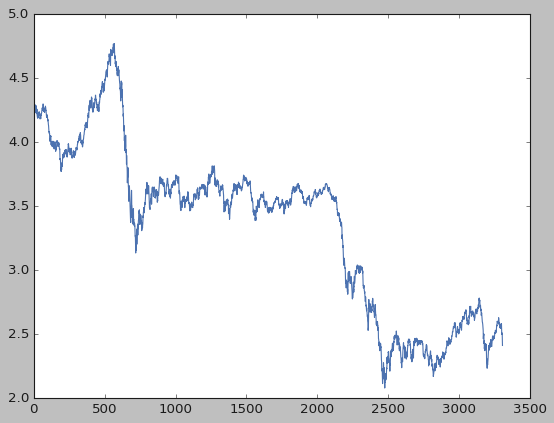

In [ ]:
df1 = df.copy()
# Take log of close price
log_close = np.log(df1[" Close"].dropna().to_frame())
#df1[" Close"].head()
#log_close

mdf1= findMinD(log_close)

print("\n\n minimum fractional dimension d:", mdf1)

#Plot the fractional differece
plt.plot(log_close)

# Question 2
Using the d you found in part 1 to fractionally differentiate the USO daily price series. Use adfuller from statsmodels.tsa.stattools to determine the ADF statistics of the resulting time series. Can you conclude from these statistics that the fractionally differentiated time series is stationary?

If the p-value is less than the critical values, it means that the series is stationary. In that case, the number of differences taken can be used as the value for d. 



## 2.1 fractionally differentiate

Using the d you found in part 1 to fractionally differentiate the USO daily price series.

,Close
9,0.780229
10,0.783744
11,0.771654
12,0.768047
13,0.789676
14,0.812389
15,0.810698
16,0.772169
17,0.756771
18,0.768218


(3299, 1)

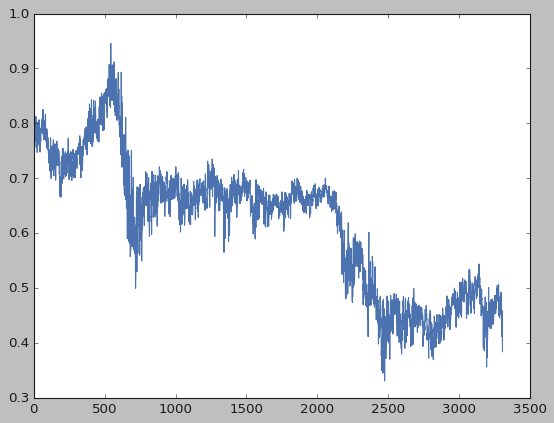

In [ ]:

# Compute the fractional difference of the bars data based on the d value from Q1
fd2 = fracDiff_FFD(log_close,mdf1,thres=0.01).dropna()
fd2.head(10)
fd2.shape

#Plot the fractional differece
plt.plot(fd2)



In [ ]:
#log_close.head()
results=adfuller(fd2[" Close"], maxlag=1, regression='c', autolag=None)
print(results)


(-3.756688620019525, 0.0033828660986461668, 1, 3297, {'1%': -3.4323349555967604, '5%': -2.862417036057391, '10%': -2.5672368644181542})


## 2.2 ADF statistics

Use adfuller from statsmodels.tsa.stattools to determine the ADF statistics of the resulting time series. 

In [ ]:

mdf2= findMinD(log_close)
print("\n\n minimum fractional dimension d:", mdf2)


ADF Test Result using adfuller in findMinD :
Test Statistic:  -0.8419108949235792
p-value:  0.8065001056314948
critical_values:  {'1%': -3.432329547701947, '5%': -2.8624146474183876, '10%': -2.56723559276082}
ADF Test Result using adfuller in findMinD :
Test Statistic:  -1.0866187064159143
p-value:  0.7203786036771909
critical_values:  {'1%': -3.432333751290419, '5%': -2.8624165041219203, '10%': -2.567236581227688}
ADF Test Result using adfuller in findMinD :
Test Statistic:  -1.374054275964656
p-value:  0.5946496973784144
critical_values:  {'1%': -3.4323355582984356, '5%': -2.8624173022673167, '10%': -2.5672370061423377}
ADF Test Result using adfuller in findMinD :
Test Statistic:  -1.9068887432205486
p-value:  0.32882740050245163
critical_values:  {'1%': -3.432336161366224, '5%': -2.8624175686388993, '10%': -2.567237147952593}
ADF Test Result using adfuller in findMinD :
Test Statistic:  -2.651044648969326
p-value:  0.08289947507581824
critical_values:  {'1%': -3.4323355582984356, '5

In [ ]:
def stationary_check(series):
    result =adfuller(series,maxlag=1,regression='c',autolag=None)
    p_value = result[1]
    print("ADF Test Result using adfuller :")
    print("Test Statistic: ", result[0])
    print("p-value: ", result[1])
    print("critical_values: ", result[4])
    # Determine the order of integration based on the p-value
    if p_value < 0.05:
      order_of_integration = 0
    else:
      order_of_integration = 1
    print("Order of Integration: ", order_of_integration)
    critical_values = result[4]
    d = 0
    if p_value < critical_values['5%']:
        d = 1
    return d


price_series = fd2[" Close"]
stationary_check(price_series)

# # Testing with provided function and it's matching
# print("\n\n*********************")
# findMinD(price_series)



ADF Test Result using adfuller :
Test Statistic:  -3.756688620019525
p-value:  0.0033828660986461668
critical_values:  {'1%': -3.4323349555967604, '5%': -2.862417036057391, '10%': -2.5672368644181542}
Order of Integration:  0


0

In the ADF test, if the calculated test statistic is less than the critical value for the chosen significance level, we reject the null hypothesis and conclude that the time series is stationary. In other words, if the p-value of the ADF test is below a certain threshold (e.g. 0.05), we reject the null hypothesis and say that the time series is stationary.

## Series is stationary

Below are the reasons:

 - Test Statistics is less than the critical values
 - p-value < 0.05 (assuming significance level)
 - d=0

# Question 3
Generate a time series from an IID Gaussian random process. This is a memoryless, stationary series:

1. Compute the ADF statistic on this series. What is the p-value? --> p-value = 1
2. Compute the cumulative sum of the observations. This is a non-stationary series without memory.
*   What is the order of integration of this cumulative series?
*   Compute the ADF statistic on this series. What is the p-value?
    
3. Differentiate the series twice. What is the p-value of this over-differentiated series?

In [ ]:
df.shape

(3308, 7)

A time series generated from an IID Gaussian random process is a white noise time series. White noise is a type of time series where the samples are independent and identically distributed random variables with a mean of zero and a constant variance. In the case of an IID Gaussian random process, the random variables are Gaussian distributed.

In other words, a time series generated from an IID Gaussian random process is a sequence of uncorrelated, identically distributed random variables with a mean of zero and a constant variance.

In [ ]:
# Set the number of observations in the time series
N = 12000
np.random.seed(0)
# Generate the time series from an IID Gaussian random process
#time_series3 = pd.Series(np.random.normal(size=num_obs))
time_series3 = pd.Series(np.random.randn(N))
#  df_=pd.Series(series[name].values,index=series.index).fillna(method='ffill').dropna()


dfq3 = pd.DataFrame(time_series3, columns = ['time_series3'])
#log_random_series = np.log(dfq3["random_series"].fillna(method='ffill').dropna().to_frame())
#log_random_series


## 3.1 Augmented Dickey-Fuller test (ADF)
The output will show the test statistic and p-value for the ADF test, as well as the critical values. The d value can be determined by the minimum number of differences required to make the series stationary, based on the p-value being less than the critical values.

In [ ]:
# # ADF Statistics using functions provided

def findMinD3(series):
    d=0
    for d in np.linspace(0,1,11):
        df_=fracDiff_FFD(series,d,thres=0.01).dropna()
        res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
        print("ADF Test Result with findMinD:")
        print("Test Statistic: ", res[0])
        print("p-value: ", res[1])
        print("critical-value: ", res[4])
        p_value = res[1]
        # Determine the order of integration based on the p-value
        if p_value < 0.05:
          order_of_integration = 0
        else:
          order_of_integration = 1
        print("Order of Integration: ", order_of_integration)
        if (res[0]<=res[4]['5%']):
            return d
    return 1.0


In [ ]:
print("\n\n****Using findMinD function*****************")

findMinD3(dfq3)
print("\n\n****stationary_check*****************")

stationary_check(dfq3)



****Using findMinD function*****************
ADF Test Result with findMinD:
Test Statistic:  -76.54344594341781
p-value:  0.0
critical-value:  {'1%': -3.4308951491597193, '5%': -2.861780927918845, '10%': -2.5668982408836767}
Order of Integration:  0


0.0



****stationary_check*****************
ADF Test Result using adfuller :
Test Statistic:  -76.54344594341781
p-value:  0.0
critical_values:  {'1%': -3.4308951491597193, '5%': -2.861780927918845, '10%': -2.5668982408836767}
Order of Integration:  0


0

## 3.2 - Cummulative Sum

Compute the cumulative sum of the observations. This is a non-stationary series without memory.
 - What is the order of integration of this cumulative series? --> Order of Integration:  1

 - Compute the ADF statistic on this series. What is the p-value? --> ADF Statistic: -3.472273
p-value: 0.008728


In [ ]:


# Compute the cumulative sum of the observations
cumulative_series3 = time_series3.cumsum()
cumulative_series3


0          1.764052
1          2.164210
2          3.142948
3          5.383841
4          7.251399
            ...    
11995   -186.191711
11996   -184.652843
11997   -186.650272
11998   -186.682193
11999   -186.458227
Length: 12000, dtype: float64

The order of integration of a time series refers to the number of differences required to make the series stationary. The most common way to determine the order of integration of a cumulative series is to perform a unit root test, such as the Augmented Dickey-Fuller (ADF) test.




In [ ]:
# Perform an ADF test on the cumulative series
print("\n\n****findMinD function*****************")
findMinD3(cumulative_series3.to_frame())

print("\n\n****stationary_check*****************")
stationary_check(cumulative_series3.to_frame())



****findMinD function*****************
ADF Test Result with findMinD:
Test Statistic:  -1.3704402314893047
p-value:  0.5963625665563386
critical-value:  {'1%': -3.4308951491597193, '5%': -2.861780927918845, '10%': -2.5668982408836767}
Order of Integration:  1
ADF Test Result with findMinD:
Test Statistic:  -1.5999763453512292
p-value:  0.4836053522090522
critical-value:  {'1%': -3.4308954674702434, '5%': -2.861781068582823, '10%': -2.5668983157584044}
Order of Integration:  1
ADF Test Result with findMinD:
Test Statistic:  -1.9723832884203263
p-value:  0.29881176793744535
critical-value:  {'1%': -3.43089560400286, '5%': -2.861781128917679, '10%': -2.5668983478743455}
Order of Integration:  1
ADF Test Result with findMinD:
Test Statistic:  -2.554680436153522
p-value:  0.1027302391823034
critical-value:  {'1%': -3.4308956495289222, '5%': -2.8617811490360094, '10%': -2.5668983585832317}
Order of Integration:  1
ADF Test Result with findMinD:
Test Statistic:  -3.3378728715269457
p-value:

0.4



****stationary_check*****************
ADF Test Result using adfuller :
Test Statistic:  -1.3704402314893047
p-value:  0.5963625665563386
critical_values:  {'1%': -3.4308951491597193, '5%': -2.861780927918845, '10%': -2.5668982408836767}
Order of Integration:  1


0

## 3.3 Differentiate the series twice

In [ ]:
differentiated_cumulative_series3 = np.diff(cumulative_series3, n=2)
print(differentiated_cumulative_series3)
print(type(differentiated_cumulative_series3))

[ 0.57858078  1.26215522 -0.37333521 ... -3.53629814  1.96550888
  0.25588667]
<class 'numpy.ndarray'>


In [ ]:
df3_3 = pd.DataFrame(differentiated_cumulative_series3, columns = ['cum_series'])

df3_3.head()
print(type(df3_3))

,cum_series
0,0.578581
1,1.262155
2,-0.373335
3,-2.844836
4,1.927366


<class 'pandas.core.frame.DataFrame'>


In [ ]:


# Perform an ADF test on the cumulative series
print("\n\n****findMinD function*****************")
findMinD3(df3_3)

print("\n\n****stationary_check*****************")
stationary_check(df3_3)




****findMinD function*****************
ADF Test Result with findMinD:
Test Statistic:  -131.67469754987164
p-value:  0.0
critical-value:  {'1%': -3.4308952400676684, '5%': -2.8617809680917996, '10%': -2.566898262267538}
Order of Integration:  0


0.0



****stationary_check*****************
ADF Test Result using adfuller :
Test Statistic:  -131.67469754987164
p-value:  0.0
critical_values:  {'1%': -3.4308952400676684, '5%': -2.8617809680917996, '10%': -2.566898262267538}
Order of Integration:  0


0

Observation: A p-value of 2.6528811443868822e-30, which is extremely close to zero, means that there is strong evidence against the null hypothesis and in favor of the alternative hypothesis. This suggests that the time series is indeed stationary

In [ ]:
orders = [0, 1, 2, 3, 4]

p_val = lambda x: adfuller(x)[1]

for o in orders:
    diff_ = np.diff(cumulative_series3,o)
    print('='*27)
    print(f'order: {o}, pVal: {p_val(diff_)}')

order: 0, pVal: 0.5618156856805528
order: 1, pVal: 0.0
order: 2, pVal: 0.0
order: 3, pVal: 0.0
order: 4, pVal: 0.0


# Question 4

Can you tell the difference between the functions we provided versus the ones provided in Chapter 5 of AFML? How much time does it take to run for parts 2 and 3 respectively? 

In [ ]:
# Functions from AFML, Chapter 5

def getWeights_FFD_AFML(d,thres):
    # thres>0 drops insignificant weights
    w,k=[1.],1
    while True:
        print("***********  getWeights_FFD_AFML CheckPoint ***********")
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_)
        k+=1
    w=np.array(w[::-1]).reshape(-1,1)
    return w
#---------------------------------------------------------------------------
def fracDiff_FFD_AFML(series,d,thres=1e-5):
    '''
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w=getWeights_FFD_AFML(d,thres)
    width=len(w)-1
    #2) Apply weights to values
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
        if not np.isfinite(series.loc[loc1,name]):continue # exclude NAs
        df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        print("***********  fracDiff_FFD_AFML CheckPoint ***********")
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

# Function provided by Scott
# for name in series.columns:
#         df_=pd.Series(series[name].values,index=series.index).fillna(method='ffill').dropna()
#         x=pd.Series(0,index=df_.index)
#         for k in range(w.shape[0]):
#             x=x+w[k,0]*df_.shift(-k)
#     #df[name]=x.dropna().copy(deep=True)
#     df[name]=x.shift(k).copy(deep=True)
#     df=pd.concat(df,axis=1)

In [ ]:
def findMinD_AFML(series):
    for d in np.linspace(0,1,11):
        df_=fracDiff_FFD_AFML(series,d,thres=0.01).dropna()
        print("***********  findMinD_AFML CheckPoint ***********")
        res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
        print("ADF Test Result with findMinD:")
        print("Test Statistic: ", res[0])
        print("p-value: ", res[1])
        p_value = res[1]
        # Determine the order of integration based on the p-value
        if p_value < 0.05:
          order_of_integration = 0
        else:
          order_of_integration = 1
        print("Order of Integration: ", order_of_integration)
        if (res[0]<=res[4]['5%']):
            return d
    return 1.0


## Q4 - part 2

In [ ]:

#findMinD_AFML(log_close)
